## Sentiment Analysis of Airline Reviews

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import math

In [120]:
df = pd.read_csv("./data/AirlineD2.csv")
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (14640, 3)
Columns: Index(['airline_sentiment', 'airline', 'text'], dtype='object')


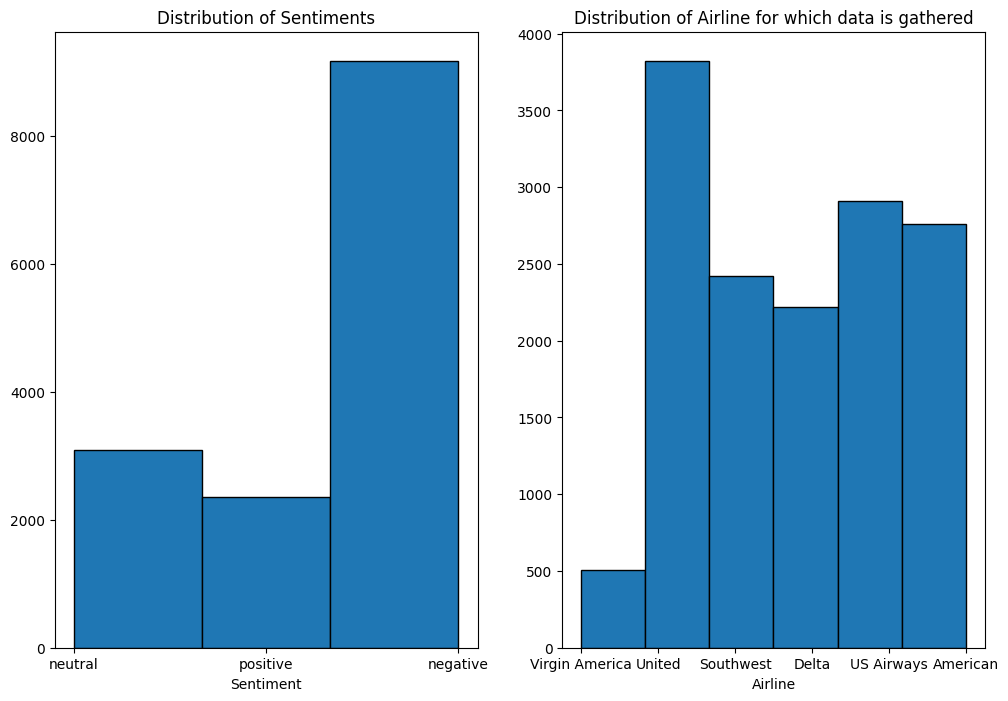

In [121]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
ax1.title.set_text("Distribution of Sentiments")
ax1.set(xlabel="Sentiment")
ax1.hist(x=df.airline_sentiment, bins=3, edgecolor='black')

ax2.title.set_text("Distribution of Airline for which data is gathered")
ax2.set(xlabel="Airline")
ax2.hist(x=df.airline, bins=len(df.airline.unique()), edgecolor='black')
plt.show()

A large proportion of the dataset is labeled with the negative class. The amount of data for each airline is roughly similar except for VirginAmerica.

In [122]:
# changing categorical labels to numerical values
df.loc[df.airline_sentiment == "negative", "airline_sentiment"] = -1
df.loc[df.airline_sentiment == "neutral", "airline_sentiment"] = 0
df.loc[df.airline_sentiment == "positive", "airline_sentiment"] = 1
df = df.astype(dtype={"airline_sentiment": "int64"})

### Data preparation

In [123]:
# cleaning review values
df.text.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [124]:
sw = stopwords.words('english')
print(sw)
sw.remove("not")

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [125]:
cleaned_text = []
ps = PorterStemmer()
fdist = FreqDist()
for text in df.text:
    # remove all @ mentions
    clean_text = re.sub("@[\w]+", '', text)
    # decontracting negated words
    clean_text = re.sub("n't", " not", clean_text)
    # remove all non-alphabetical characters
    clean_text = re.sub("[^a-zA-z]", ' ', clean_text)

    clean_text = clean_text.strip()
    # convert to lowercase
    clean_text = [ps.stem(i) for i in clean_text.lower().split(" ") if i not in sw and i != ""]
    for word in clean_text:
        fdist[word] += 1
    cleaned_text.append(clean_text)
    # cleaned_text.append(' '.join(clean_text))

In [126]:
# filtering out words which only occur once
print("Before filtering, number of words in corpus =", len(fdist.keys()))
filtered_words = list(filter(lambda x : x[1] >= 3, fdist.items()))
print("After filtering =",len(filtered_words))

Before filtering, number of words in corpus = 10067
After filtering = 3311


In [127]:
for i in range(df.shape[0]):
    cleaned_text[i] = ' '.join([word for word in cleaned_text[i] if fdist.get(word) >= 3])

Filtering out uncommon words leads to extremely minute improvements in this case of the NB implementations, however it might help in improving performance of other algorithms like logistic regression

In [128]:
df = df.assign(cleaned_text=pd.Series(cleaned_text))
df.head(20)

,airline_sentiment,airline,text,cleaned_text
0,0,Virgin America,@VirginAmerica What @dhepburn said.,said
1,1,Virgin America,@VirginAmerica plus you've added commercials t...,plu ad commerci experi
2,0,Virgin America,@VirginAmerica I didn't today... Must mean I n...,not today must mean need take anoth trip
3,-1,Virgin America,@VirginAmerica it's really aggressive to blast...,realli aggress blast entertain guest face amp ...
4,-1,Virgin America,@VirginAmerica and it's a really big bad thing...,realli big bad thing
5,-1,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,serious would pay flight seat not play realli ...
6,1,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...",ye nearli everi time fli vx ear go away
7,0,Virgin America,@VirginAmerica Really missed a prime opportuni...,realli miss prime opportun men without hat htt...
8,1,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D",well not
9,1,Virgin America,"@VirginAmerica it was amazing, and arrived an ...",amaz arriv hour earli good


In [129]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(df.cleaned_text)
print(vectorizer.get_feature_names_out().shape)
print(features.shape)

(3287,)
(14640, 3287)


In [130]:
# transform data
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(df.cleaned_text).toarray()
print(vectorizer.get_feature_names_out().shape)
print(features.shape)

(3287,)
(14640, 3287)


### Training the Model - Naive Bayes

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

In [132]:
x_train, x_test, y_train, y_test = train_test_split(features, df.airline_sentiment, random_state=10, train_size=0.8)
MNB = MultinomialNB()
MNB.fit(x_train, y_train)

MultinomialNB()

Multinomial Naive Bayes
Accuracy:  0.7653688524590164
Confusion Matrix


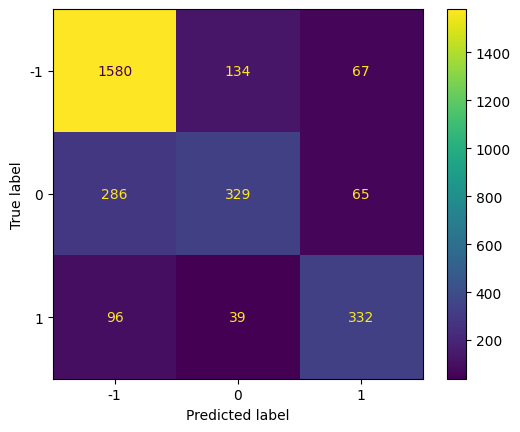

Classification Report
              precision    recall  f1-score   support

          -1       0.81      0.89      0.84      1781
           0       0.66      0.48      0.56       680
           1       0.72      0.71      0.71       467

    accuracy                           0.77      2928
   macro avg       0.73      0.69      0.70      2928
weighted avg       0.76      0.77      0.76      2928



In [133]:
# decent results with filtering freq >= 2
pred = MNB.predict(x_test)
accuracy = accuracy_score(y_test, pred)
mlb_report = classification_report(y_test, pred, labels=(-1,0,1))
print("Multinomial Naive Bayes")
print("Accuracy: ", accuracy)
print("Confusion Matrix")
cfm_mnb = confusion_matrix(y_test, pred, labels=(-1,0,1))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cfm_mnb,
    display_labels=(-1,0,1)
)
disp.plot()
plt.show()
print("Classification Report")
print(mlb_report)

The precision (PPV) of the model is relatively equal across the classes however the model seems to be biased towards misclassifying negative comments and has poor specificity for the neutral and positive labels

In [134]:
# Testing the Complement Naive Bayes algorithm
CNB = ComplementNB()
CNB.fit(x_train, y_train)

ComplementNB()

Complement Naive Bayes
Accuracy:  0.7640027322404371
Confusion Matrix


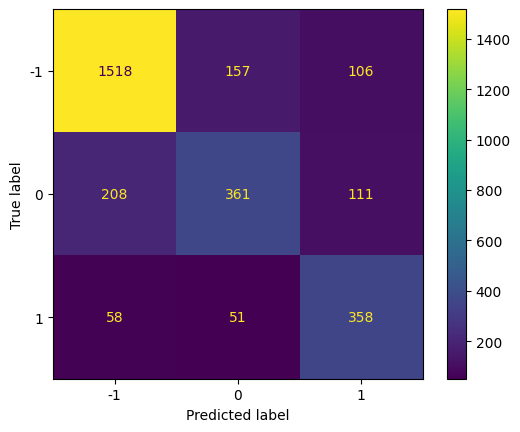

Classification Report
              precision    recall  f1-score   support

          -1       0.85      0.85      0.85      1781
           0       0.63      0.53      0.58       680
           1       0.62      0.77      0.69       467

    accuracy                           0.76      2928
   macro avg       0.70      0.72      0.71      2928
weighted avg       0.76      0.76      0.76      2928



In [135]:
# decent results with filtering freq >= 2
pred = CNB.predict(x_test)
accuracy = accuracy_score(y_test, pred)
cnb_report = classification_report(y_test, pred, labels=(-1,0,1))
print("Complement Naive Bayes")
print("Accuracy: ", accuracy)
print("Confusion Matrix")
cfm_cnb = confusion_matrix(y_test, pred, labels=(-1,0,1))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cfm_cnb,
    display_labels=(-1,0,1)
)
disp.plot()
plt.show()
print("Classification Report")
print(cnb_report)

There is no significant difference in the accuracy of the model however ComplementNB seems to provide a slightly better recall for positive and neutral reviews with a slight hit on their precision scores.

### Logistic Regression

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import time

In [137]:
start = time.time()
lr = LogisticRegression(penalty='l2', class_weight='balanced',
                            random_state=0,
                            max_iter=200,
                           solver="lbfgs").fit(x_train, y_train)
print("Time taken to train =",time.time()-start)

Time taken to train = 5.975774526596069


Logistic Regression
Accuracy:  0.7520491803278688
Confusion Matrix


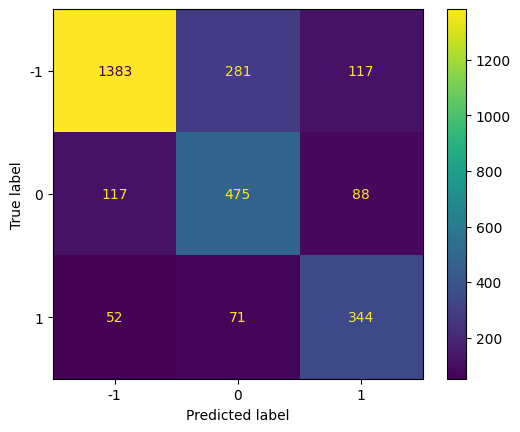

Classification Report
              precision    recall  f1-score   support

          -1       0.89      0.78      0.83      1781
           0       0.57      0.70      0.63       680
           1       0.63      0.74      0.68       467

    accuracy                           0.75      2928
   macro avg       0.70      0.74      0.71      2928
weighted avg       0.78      0.75      0.76      2928



In [138]:
lr_preds = lr.predict(x_test)
accuracy = accuracy_score(y_test, lr_preds)
lr_report = classification_report(y_test, lr_preds, labels=lr.classes_)
print("Logistic Regression")
print("Accuracy: ", accuracy)
print("Confusion Matrix")
cfm_lr = confusion_matrix(y_test, lr_preds, labels=lr.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cfm_lr,
    display_labels=lr.classes_
)
disp.plot()
plt.show()
print("Classification Report")
print(lr_report)

### Experiments

TL;DR Vectorization of words within the corpus w.r.t to the sentiment which they most frequently correspond to.
What if we consider each class label to be one axis in an n-dimensional space, where n=# of classes. Then each word present in the (filtered) corpus would contain a vector with the coefficients of each of the component equal to the frequency with which that word appeared in samples corresponding to that label. Then predictions could be done by adding all the vectors in the test sample and analyzing where the resultant vector lies and which component has the greatest magnitude.

In [139]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [151]:
class MultilabelSentimentClassifier:
    def __init__(self):
        self.fdist = None
        self.num_lables = None
        self.word2vectors = None

    def clean_data(self, data, freq=2):
        cleaned_text = []
        ps = PorterStemmer()
        self.fdist = FreqDist()
        for text in data:
            # remove all @ mentions
            clean_text = re.sub("@[\w]+", '', text)
            # decontracting negated words
            clean_text = re.sub("n't", " not", clean_text)
            # remove all non-alphabetical characters
            clean_text = re.sub("[^a-zA-z]", ' ', clean_text)
        
            clean_text = clean_text.strip()
            # convert to lowercase
            clean_text = [ps.stem(i) for i in clean_text.lower().split(" ") if i not in sw and i != ""]
            for word in clean_text:
                self.fdist[word] += 1
            cleaned_text.append(clean_text)
        for i in range(df.shape[0]):
            cleaned_text[i] = ' '.join([word for word in cleaned_text[i] if self.fdist.get(word) >= freq])
        return cleaned_text

    def fit(self, x, y, is_clean=True, freq=2, amb_factor=5):
        self.num_labels = len(np.unique(y))
        if not is_clean:
            x_clean = self.clean_data(x, freq)
        else:
            x_clean = x
        if not self.fdist:
            self.fdist = FreqDist()
            for text in x_clean:
                words = text.split(" ")
                for word in words:
                    self.fdist[word] += 1
        self.filtered_words = list(filter(lambda x : x[1] >= freq, self.fdist.items()))
        # create a dictionary where each word in the corpus corresponds to its vector value
        self.word2vectors = dict([(key, np.zeros(self.num_labels)) for key, _ in filtered_words])
        for i in range(x.size):
            text = x.iloc[i].split(" ")
            for word in text:
                if word == "":
                    continue
                self.word2vectors[word][y.iloc[i] + 1] += 1 # (-1,0,1) sentiment -> (0, 1, 2) index values
        for word in self.word2vectors.keys():
            v = self.word2vectors[word]
            ambiguity = 0
            if v.tolist().count(v[0]) == v.size:
                ambiguity = 1
            else:
                for c in v:
                    ambiguity += amb_factor # if a word occurs in all types of reviews frequently then it must be ambiguous and not a clear identifier of sentiment
            self.word2vectors[word] *= 1 - (1 / math.exp(ambiguity)) # exponentiating the ambiguity results in better outputs
        self.corpus = np.array(sorted(self.word2vectors.keys()))
        self.corpus_vectors = np.zeros((self.corpus.size, 3))
        for i in range(self.corpus.size):
            self.corpus_vectors[i] = self.word2vectors[self.corpus[i]]
        self.scaled_vectors = StandardScaler().fit_transform(self.corpus_vectors)
    
    def predict_single(self, x):
            resultant = np.zeros(self.num_labels)
            words = x.split(" ")
            if '' in words:
                words.remove('')
            for word in words:
                resultant += self.scaled_vectors[np.where(self.corpus == word)[0][0]] # scaling makes a pretty big difference !
            result = max(resultant)
            resultant = resultant.tolist()
            return resultant.index(result) - 1
        
    def get_resultant(self, x):
        resultant = np.zeros(self.num_labels)
        words = x.split(" ")
        for word in words:
            if word == '' or word not in self.word2vectors.keys():
                continue
            resultant += np.array(self.word2vectors[word])
        return resultant

    def predict(self, x):
        preds = np.zeros(x.size)
        for i in range(x.size):
            preds[i] = self.predict_single(x.iloc[i])
        return preds

In [163]:
x_train, x_test, y_train, y_test = train_test_split(df.cleaned_text, df.airline_sentiment,test_size=0.2)

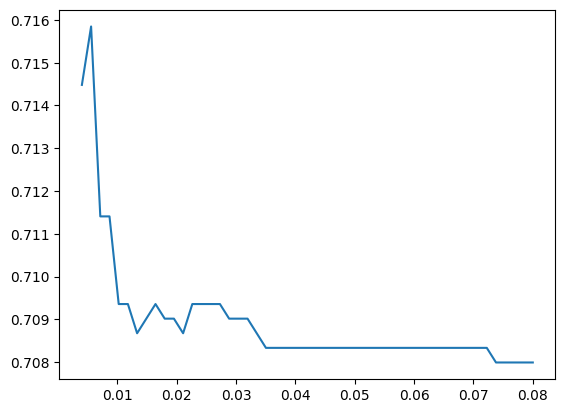

In [165]:
acc_arr = []
for i in np.linspace(0.004, 0.08, 50):
    msc = MultilabelSentimentClassifier()
    msc.fit(x_train, y_train, is_clean=True, amb_factor=i)
    preds = msc.predict(x_test)
    acc_arr.append(accuracy_score(y_test, preds))
plt.plot(np.linspace(0.004, 0.08, 50), acc_arr, '-')
plt.show()

The variation in between accuracies is quite minimal with a range of only 0.007

In [178]:
msc = MultilabelSentimentClassifier()
msc.fit(x_train, y_train, is_clean=True, amb_factor=0.015)

Accuracy: 0.7090163934426229
Confusion Matrix


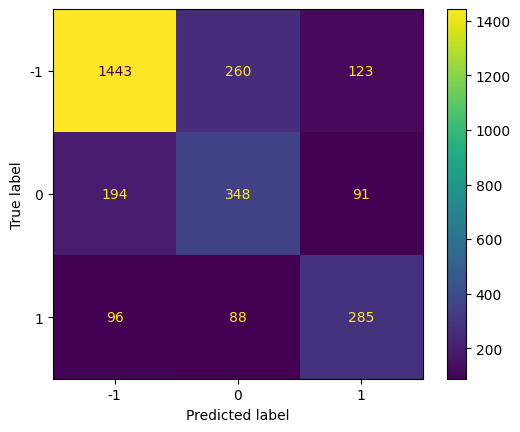

              precision    recall  f1-score   support

          -1       0.83      0.79      0.81      1826
           0       0.50      0.55      0.52       633
           1       0.57      0.61      0.59       469

    accuracy                           0.71      2928
   macro avg       0.63      0.65      0.64      2928
weighted avg       0.72      0.71      0.71      2928



In [179]:
preds = msc.predict(x_test)
msc_acc = accuracy_score(y_test, preds)
msc_cfm = confusion_matrix(y_test, preds)
msc_report = classification_report(y_test, preds)
print("Accuracy:",msc_acc)
print("Confusion Matrix")
msc_cfm = confusion_matrix(y_test, preds, labels=(-1,0,1))
disp = ConfusionMatrixDisplay(
    confusion_matrix=msc_cfm,
    display_labels=(-1,0,1)
)
disp.plot()
plt.show()
print(msc_report)

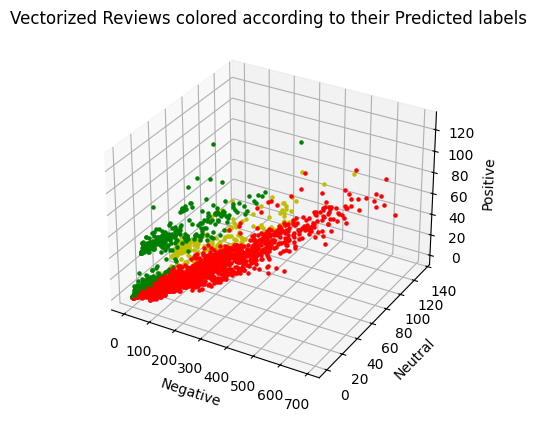

In [180]:
fig = plt.figure()
vectors = [msc.get_resultant(i) for i in x_test]
ax = fig.add_subplot(projection="3d")
colors = ['r','y','g']
for i in range(len(vectors)):
    v = vectors[i]
    ax.scatter(v[0],v[1],v[2],c=colors[int(preds[i] + 1)], marker='.')
plt.title("Vectorized Reviews colored according to their Predicted labels")
ax.set_xlabel("Negative")
ax.set_ylabel("Neutral")
ax.set_zlabel("Positive")
plt.show()

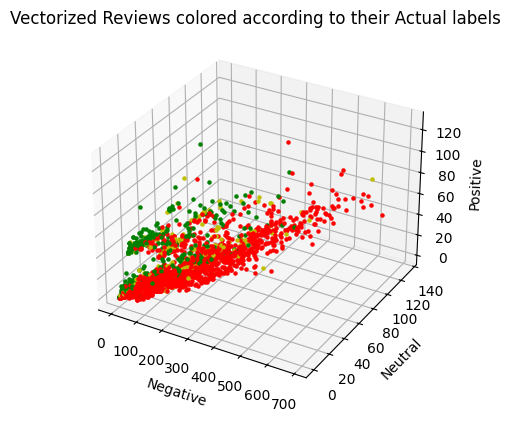

In [181]:
fig = plt.figure()
vectors = [msc.get_resultant(i) for i in x_test]
ax = fig.add_subplot(projection="3d")
colors = ['r','y','g']
for i in range(len(vectors)):
    v = vectors[i]
    ax.scatter(v[0],v[1],v[2],c=colors[int(y_test.iloc[i] + 1)], marker='.')
plt.title("Vectorized Reviews colored according to their Actual labels")
# ax.axes.set_xlim3d(left=0, right=1500)
ax.set_xlabel("Negative")
ax.set_ylabel("Neutral")
ax.set_zlabel("Positive")
plt.show()

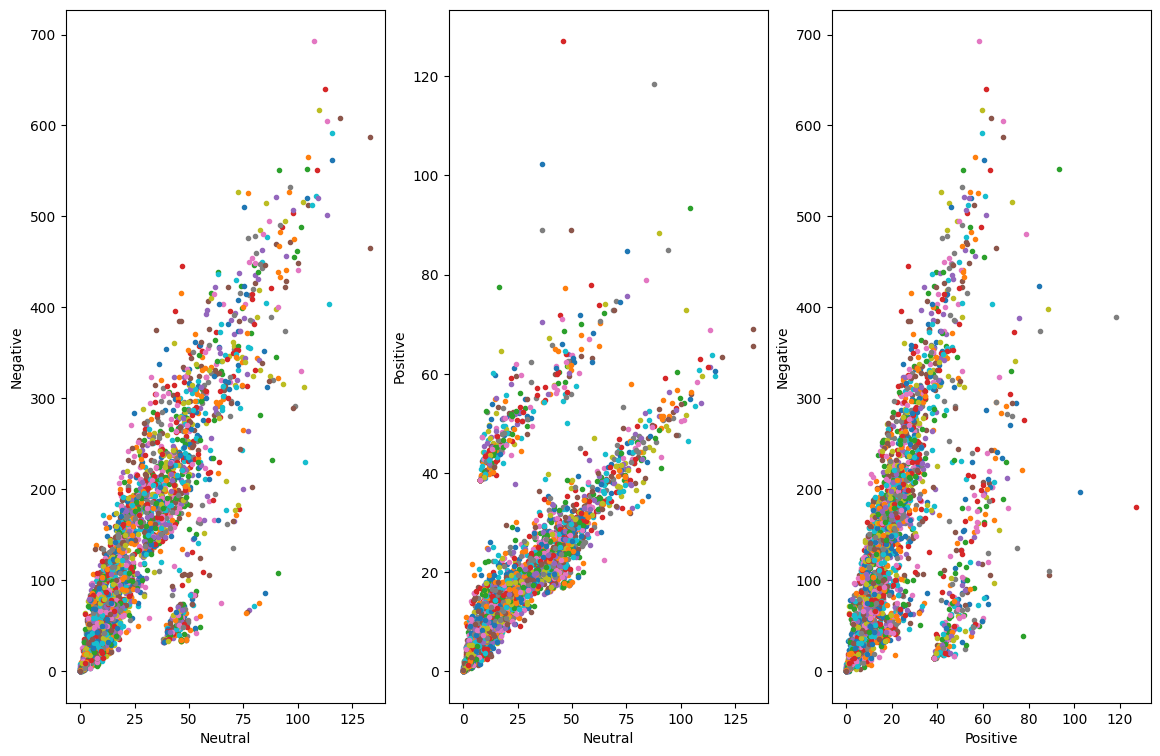

In [183]:
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(14,9))
ax[0].set_xlabel("Neutral")
ax[0].set_ylabel("Negative")
ax[1].set_xlabel("Neutral")
ax[1].set_ylabel("Positive")
ax[2].set_xlabel("Positive")
ax[2].set_ylabel("Negative")

for v in vectors:
    ax[0].scatter(v[1],v[0], marker='.')
    ax[1].scatter(v[1],v[2], marker='.')
    ax[2].scatter(v[2],v[0], marker='.')
plt.show()

The classifier performs fairly well but the main problem seems to be that words that don't necessarily have a negative connotation seem to have highly negative vectorized values due to the bias of the dataset which are slightly but not completely mitigated by the scaling and the ambiguity factor. Perhaps this model would perform better on a larger dataset with a more normal distribution of words. \
Another observation highligted by these graphs and the confusion matrix is the 
Would KNN work better ??

In [184]:
train_pts = StandardScaler().fit_transform(np.array([msc.get_resultant(i) for i in x_train]))
test_pts = StandardScaler().fit_transform(np.array([msc.get_resultant(i) for i in x_test]))

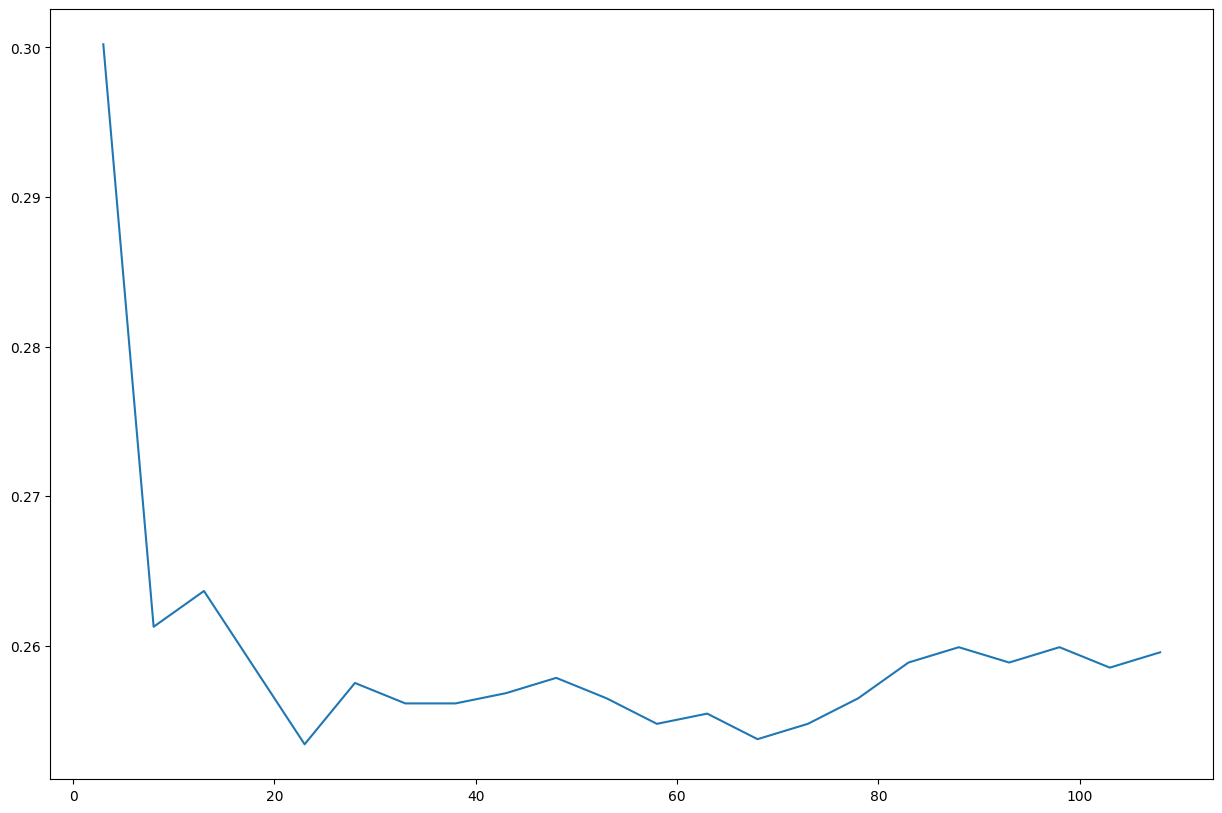

Best K at 23 with error 0.25341530054644806


In [185]:
k = round(math.sqrt(x_train.size))
error = []
lowest_err = 100
best_k = 0
for i in range(3, 110, 5):
    knn = KNeighborsClassifier(n_neighbors=i)
    clf = knn.fit(train_pts, y_train)
    pred = knn.predict(test_pts)
    err = np.mean(pred != y_test)
    if err < lowest_err:
        lowest_err = err
        best_k = i
    error.append(err)
plt.figure(figsize=(15,10))
plt.plot([i for i in range(3, 110, 5)],error)
plt.show()
print(f"Best K at {best_k} with error {lowest_err}")

Accuracy: 0.7435109289617486
Confusion Matrix


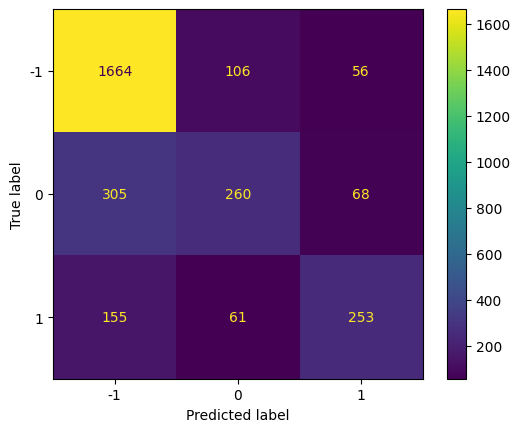

              precision    recall  f1-score   support

          -1       0.78      0.91      0.84      1826
           0       0.61      0.41      0.49       633
           1       0.67      0.54      0.60       469

    accuracy                           0.74      2928
   macro avg       0.69      0.62      0.64      2928
weighted avg       0.73      0.74      0.73      2928



In [186]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(train_pts, y_train)
preds = knn.predict(test_pts)
knn_acc = accuracy_score(y_test, preds)
knn_cfm = confusion_matrix(y_test, preds)
knn_report = classification_report(y_test, preds)
print("Accuracy:",knn_acc)
print("Confusion Matrix")
knn_cfm = confusion_matrix(y_test, preds, labels=(-1,0,1))
disp = ConfusionMatrixDisplay(
    confusion_matrix=knn_cfm,
    display_labels=(-1,0,1)
)
disp.plot()
plt.show()
print(knn_report)